In [11]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        # Optional: restrict visible devices
        tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)  # Already initialized


In [12]:
#imports
# For Data Processing
import numpy as np
from fontTools.subset import subset
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# For ML Models
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.utils import load_img
from tensorflow.keras.callbacks import EarlyStopping

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#miscellaneous
#from tqdm import tqdm
import os
import random
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt


In [13]:
import tensorflow as tf

# TensorFlow version
print("TensorFlow version:", tf.__version__)

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)


TensorFlow version: 2.18.1
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
batch_size = 8
img_height = 320
img_width = 320
data_dir = "Brain_Tumor_new/Training"
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 8582 files belonging to 4 classes.
Using 6866 files for training.
Found 8582 files belonging to 4 classes.
Using 1716 files for validation.


In [15]:
NUM_CLASSES = 4
IMAGE_SIZE_XCEPTION = 299
xception_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomCrop(IMAGE_SIZE_XCEPTION, IMAGE_SIZE_XCEPTION),
    tf.keras.layers.Resizing(IMAGE_SIZE_XCEPTION, IMAGE_SIZE_XCEPTION)
])
def preprocess_xception_train(x, y):
    x = tf.image.resize(x, [IMAGE_SIZE_XCEPTION, IMAGE_SIZE_XCEPTION])
    x = xception_augmentation(x)
    x = tf.keras.applications.xception.preprocess_input(x)
    return x, y
def preprocess_xception_val(x, y):
    x = tf.image.resize(x, [IMAGE_SIZE_XCEPTION, IMAGE_SIZE_XCEPTION])
    x = tf.keras.applications.xception.preprocess_input(x)
    return x, y

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping


train_ds_xception = train_ds.map(preprocess_xception_train, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_xception   = val_ds.map(preprocess_xception_val, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_xception = train_ds_xception.prefetch(tf.data.AUTOTUNE)
val_ds_xception   = val_ds_xception.prefetch(tf.data.AUTOTUNE)

In [17]:
train_batches = tf.data.experimental.cardinality(train_ds_xception).numpy()
print("Number of batches in train_ds:", train_batches)

num_train_samples = train_batches * batch_size
print("Estimated number of training samples:", num_train_samples)

Number of batches in train_ds: 859
Estimated number of training samples: 6872


In [18]:
from tensorflow.keras.applications import Xception
base_model = Xception(
    include_top=False,
    weights="xception_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape=(IMAGE_SIZE_XCEPTION, IMAGE_SIZE_XCEPTION, 3),
    pooling='max'
)
base_model.trainable = False  # freeze base


model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(NUM_CLASSES, activation='softmax')
])

early_stop = EarlyStopping(
    monitor='val_loss',       # or 'val_accuracy' if you prefer
    patience=3,               # number of epochs with no improvement to wait
    restore_best_weights=True # restore model weights from the epoch with the best value
)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "xception_before_unfreezing.h5", 
    monitor="val_loss", 
    save_best_only=True,
    verbose=1
)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds_xception,
    validation_data=val_ds_xception,
    epochs=10,
    batch_size=batch_size,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/10
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6535 - loss: 0.9534
Epoch 1: val_loss improved from None to 0.41581, saving model to xception_before_unfreezing.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 80s 87ms/step - accuracy: 0.7357 - loss: 0.6900 - val_accuracy: 0.8438 - val_loss: 0.4158
Epoch 2/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7920 - loss: 0.5438
Epoch 2: val_loss improved from 0.41581 to 0.34420, saving model to xception_before_unfreezing.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 70s 81ms/step - accuracy: 0.8009 - loss: 0.5098 - val_accuracy: 0.8741 - val_loss: 0.3442
Epoch 3/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8073 - loss: 0.4766
Epoch 3: val_loss did not improve from 0.34420
859/859 ━━━━━━━━━━━━━━━━━━━━ 69s 80ms/step - accuracy: 0.8188 - loss: 0.4571 - val_accuracy: 0.8479 - val_loss: 0.3879
Epoch 4/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8215 - loss: 0.4488
Epoch 4: val_loss improved from 0.34420 to 0.29336, saving model to xception_before_unfreezing.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 69s 80ms/step - accuracy: 0.8238 - loss: 0.4425 - val_accuracy: 0.8846 - val_loss: 0.2934
Epoch 5/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8297 - loss: 0.4257
Epoch 5: val_loss improved from 0.29336 to 0.29025, saving model to xception_before_unfreezing.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 68s 79ms/step - accuracy: 0.8439 - loss: 0.4050 - val_accuracy: 0.8980 - val_loss: 0.2903
Epoch 6/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8373 - loss: 0.4315
Epoch 6: val_loss did not improve from 0.29025
859/859 ━━━━━━━━━━━━━━━━━━━━ 75s 87ms/step - accuracy: 0.8405 - loss: 0.4121 - val_accuracy: 0.8875 - val_loss: 0.3151
Epoch 7/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8404 - loss: 0.4100
Epoch 7: val_loss improved from 0.29025 to 0.26698, saving model to xception_before_unfreezing.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 78s 90ms/step - accuracy: 0.8479 - loss: 0.3924 - val_accuracy: 0.8963 - val_loss: 0.2670
Epoch 8/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8569 - loss: 0.3805
Epoch 8: val_loss did not improve from 0.26698
859/859 ━━━━━━━━━━━━━━━━━━━━ 70s 82ms/step - accuracy: 0.8522 - loss: 0.3902 - val_accuracy: 0.8899 - val_loss: 0.2901
Epoch 9/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8530 - loss: 0.3842
Epoch 9: val_loss improved from 0.26698 to 0.26629, saving model to xception_before_unfreezing.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 68s 79ms/step - accuracy: 0.8579 - loss: 0.3782 - val_accuracy: 0.8963 - val_loss: 0.2663
Epoch 10/10
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8656 - loss: 0.3535
Epoch 10: val_loss did not improve from 0.26629
859/859 ━━━━━━━━━━━━━━━━━━━━ 69s 80ms/step - accuracy: 0.8651 - loss: 0.3510 - val_accuracy: 0.9009 - val_loss: 0.2760


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
trainable = 30
# -------------------------------
# 1. Load previously trained top model
# -------------------------------
xception_finetune = load_model("xception_before_unfreezing.h5")
for layer in xception_finetune .layers[:(len(xception_finetune.layers) - trainable)]:
    layer.trainable = False

for layer in xception_finetune.layers[(len(xception_finetune.layers) - trainable):]:
    layer.trainable = True

xception_finetune.compile(
    optimizer=Adam(learning_rate=1e-7),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [23]:
xception_finetune = load_model("xception_before_unfreezing.h5")
xception_finetune.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,270 (80.58 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 2 (12.00 B)

In [25]:
xception_finetune = load_model("xception_before_unfreezing.h5")

# Get the base Xception model (first layer of Sequential)
base_model = xception_finetune.layers[0]

# Freeze everything first
for layer in base_model.layers:
    layer.trainable = False

#
for layer in base_model.layers[-20:]:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_after_finetune = ModelCheckpoint(
    "xception_after_unfreezing_final.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

xception_finetune.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_after_unfreeze = xception_finetune.fit(
    train_ds_xception,
    validation_data=val_ds_xception,
    epochs=20,
    callbacks=[early_stop, checkpoint_after_finetune],
    verbose=1
)


Epoch 1/20
859/859 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8105 - loss: 0.5265
Epoch 1: val_loss improved from None to 0.12599, saving model to xception_after_unfreezing_final.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 96s 103ms/step - accuracy: 0.8657 - loss: 0.3648 - val_accuracy: 0.9493 - val_loss: 0.1260
Epoch 2/20
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9287 - loss: 0.2007
Epoch 2: val_loss improved from 0.12599 to 0.08203, saving model to xception_after_unfreezing_final.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 85s 99ms/step - accuracy: 0.9375 - loss: 0.1759 - val_accuracy: 0.9720 - val_loss: 0.0820
Epoch 3/20
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9580 - loss: 0.1288
Epoch 3: val_loss improved from 0.08203 to 0.07626, saving model to xception_after_unfreezing_final.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 84s 98ms/step - accuracy: 0.9626 - loss: 0.1134 - val_accuracy: 0.9761 - val_loss: 0.0763
Epoch 4/20
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9685 - loss: 0.0876
Epoch 4: val_loss improved from 0.07626 to 0.04700, saving model to xception_after_unfreezing_final.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 84s 97ms/step - accuracy: 0.9732 - loss: 0.0760 - val_accuracy: 0.9854 - val_loss: 0.0470
Epoch 5/20
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9777 - loss: 0.0804
Epoch 5: val_loss did not improve from 0.04700
859/859 ━━━━━━━━━━━━━━━━━━━━ 83s 97ms/step - accuracy: 0.9814 - loss: 0.0593 - val_accuracy: 0.9796 - val_loss: 0.0647
Epoch 6/20
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9827 - loss: 0.0508
Epoch 6: val_loss improved from 0.04700 to 0.03352, saving model to xception_after_unfreezing_final.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 88s 102ms/step - accuracy: 0.9850 - loss: 0.0472 - val_accuracy: 0.9889 - val_loss: 0.0335
Epoch 7/20
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9897 - loss: 0.0314
Epoch 7: val_loss improved from 0.03352 to 0.02961, saving model to xception_after_unfreezing_final.h5


859/859 ━━━━━━━━━━━━━━━━━━━━ 90s 105ms/step - accuracy: 0.9885 - loss: 0.0353 - val_accuracy: 0.9878 - val_loss: 0.0296
Epoch 8/20
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9849 - loss: 0.0474
Epoch 8: val_loss did not improve from 0.02961
859/859 ━━━━━━━━━━━━━━━━━━━━ 83s 96ms/step - accuracy: 0.9883 - loss: 0.0357 - val_accuracy: 0.9901 - val_loss: 0.0351
Epoch 9/20
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9903 - loss: 0.0316
Epoch 9: val_loss did not improve from 0.02961
859/859 ━━━━━━━━━━━━━━━━━━━━ 82s 96ms/step - accuracy: 0.9911 - loss: 0.0292 - val_accuracy: 0.9878 - val_loss: 0.0530
Epoch 10/20
858/859 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9929 - loss: 0.0269
Epoch 10: val_loss did not improve from 0.02961
859/859 ━━━━━━━━━━━━━━━━━━━━ 85s 98ms/step - accuracy: 0.9920 - loss: 0.0278 - val_accuracy: 0.9883 - val_loss: 0.0542


In [27]:
xception_test = load_model("xception_after_unfreezing_final.h5")
test_ds = tf.keras.utils.image_dataset_from_directory(
    "Brain_Tumor_new/Testing",
    labels="inferred",            # infer from subfolders
    label_mode="categorical",     # ✅ one-hot encode labels
    batch_size=8,
    image_size=(299, 299),
    shuffle=False                 # don’t shuffle test set
)
test_ds_xception = test_ds.map(preprocess_xception_val, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_xception = test_ds_xception.prefetch(tf.data.AUTOTUNE)
test_loss, test_acc = xception_test.evaluate(test_ds_xception)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Found 1705 files belonging to 4 classes.
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9449 - loss: 0.3838
Test loss: 0.3838
Test accuracy: 0.9449


214/214 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step


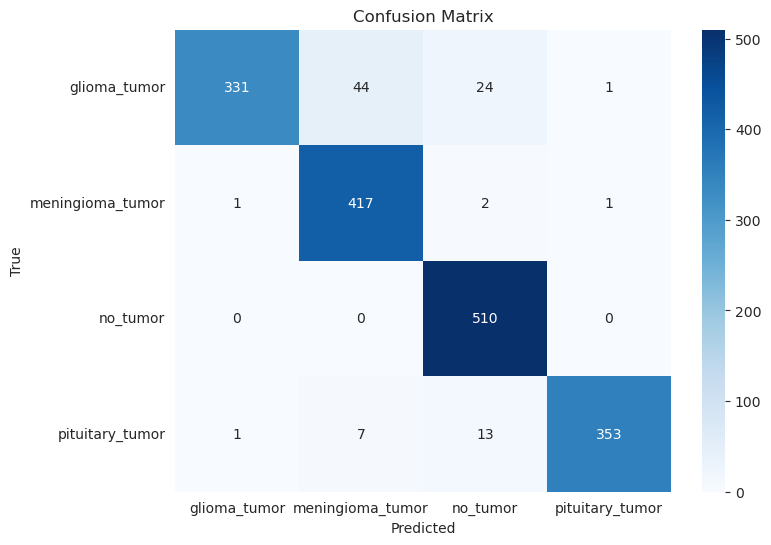

                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.83      0.90       400
meningioma_tumor       0.89      0.99      0.94       421
        no_tumor       0.93      1.00      0.96       510
 pituitary_tumor       0.99      0.94      0.97       374

        accuracy                           0.94      1705
       macro avg       0.95      0.94      0.94      1705
    weighted avg       0.95      0.94      0.94      1705



In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds_xception], axis=0)   # one-hot labels
y_true = np.argmax(y_true, axis=1)  # convert one-hot to class indices

y_pred_probs = xception_test.predict(test_ds_xception)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Get class names from dataset
class_names = test_ds.class_names   # same order as dataset

# 4. Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 5. Print detailed report
print(classification_report(y_true, y_pred, target_names=class_names))
